<a href="https://colab.research.google.com/github/MouadBaghdadi/Devfest23_challenge/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
model_url = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}

In [6]:
#Set pretrained to False
resnet50 = torchvision.models.resnet50(pretrained=False)
# resnet50.load_state_dict(torch.load('./models/resnet50-19c8e357.pth'))
resnet50.load_state_dict(torch.hub.load_state_dict_from_url(model_url['resnet50']))  #load the pretrained weights
resnet50.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
#some transformation on the train and test grayscal images
data_transforms = {
    'train':
     transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
    'test':
     transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
}

In [8]:
data_sets = {
    'train': torchvision.datasets.MNIST('./datasets/mnist/', train=True, transform=data_transforms['train'], download=True),
    'test': torchvision.datasets.MNIST('./datasets/mnist/', train=False, transform=data_transforms['test'], download=True),
}

100%|██████████| 9912422/9912422 [00:00<00:00, 105897859.01it/s]


Extracting ./datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21304202.22it/s]


Extracting ./datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25762019.41it/s]


Extracting ./datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22571716.55it/s]


Extracting ./datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



In [9]:
print(data_sets['train'])
print('='*85)
print(data_sets['test'])

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets/mnist/
    Split: Test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [10]:
#defining data loaders for both the training and testing with batch size = 64
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=64,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=64,
                                shuffle=False,
                                num_workers=0)
}

In [16]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [13]:
#modifying the final fully connected (fc) layer of the resnet50 model
resnet50 = resnet50.cuda() if use_cuda else resnet50

num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 1024)
resnet50.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

In [17]:
#after the training step and saving the weights and loosing the lab connection, i loaded the weights to the model
weights_path = '/content/drive/MyDrive/gdg_challenge/Weights.pt'
resnet50.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
resnet50.fc = resnet50.fc.cuda() if use_cuda else resnet50.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
#freezing the first 5 residual layers
for name, param in resnet50.named_parameters():
    if 'layer' in name and int(name.split('.')[1]) <= 5 :
        param.requires_grad = False

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
save_path = '/content/gdrive/MyDrive/gdg_challenge/Weights.pt'


In [30]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            resnet50.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                outputs = resnet50(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 20 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
            scheduler.step()
        else:
            with torch.no_grad():
                resnet50.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    outputs = resnet50(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])

        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(resnet50.state_dict(), save_path)
        print('Improvement-Detected, save-model')

Epoch 0

Epoch [0/14], Step [0/938], Loss: 2.3131
Epoch [0/14], Step [20/938], Loss: 2.3110
Epoch [0/14], Step [40/938], Loss: 2.3029
Epoch [0/14], Step [60/938], Loss: 2.2979
Epoch [0/14], Step [80/938], Loss: 2.2834
Epoch [0/14], Step [100/938], Loss: 2.2570
Epoch [0/14], Step [120/938], Loss: 2.2218
Epoch [0/14], Step [140/938], Loss: 2.2290
Epoch [0/14], Step [160/938], Loss: 2.2091
Epoch [0/14], Step [180/938], Loss: 2.1915
Epoch [0/14], Step [200/938], Loss: 2.1763
Epoch [0/14], Step [220/938], Loss: 2.2057
Epoch [0/14], Step [240/938], Loss: 2.1222
Epoch [0/14], Step [260/938], Loss: 2.0924
Epoch [0/14], Step [280/938], Loss: 2.0528
Epoch [0/14], Step [300/938], Loss: 1.9560
Epoch [0/14], Step [320/938], Loss: 1.8610
Epoch [0/14], Step [340/938], Loss: 1.7669
Epoch [0/14], Step [360/938], Loss: 1.6146
Epoch [0/14], Step [380/938], Loss: 1.6502
Epoch [0/14], Step [400/938], Loss: 1.5597
Epoch [0/14], Step [420/938], Loss: 1.6012
Epoch [0/14], Step [440/938], Loss: 1.5863
Epoch [0

In [34]:
num = 64
classes = data_sets['test'].classes
indices = list(range(len(data_sets['test'])))
np.random.shuffle(indices)
idx = indices[:num]
from torch.utils.data.sampler import SubsetRandomSampler
sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data_sets['test'], sampler=sampler, batch_size=num)
# dataiter = iter(loader)
# images, labels = dataiter.next()
for images, labels in loader:
    print(images.shape)  # Print the shape of the batch
    print(labels)

torch.Size([64, 3, 224, 224])
tensor([0, 4, 8, 9, 1, 7, 9, 6, 1, 2, 5, 3, 8, 5, 4, 6, 1, 0, 3, 3, 3, 7, 2, 8,
        3, 2, 1, 4, 5, 6, 6, 4, 1, 0, 4, 8, 5, 7, 8, 0, 2, 5, 3, 2, 7, 5, 9, 9,
        6, 4, 0, 1, 6, 0, 3, 2, 7, 7, 9, 2, 7, 9, 9, 2])


In [28]:
def imshow(inp, title=None):

    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

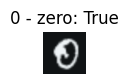

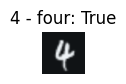

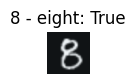

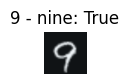

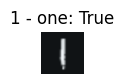

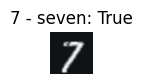

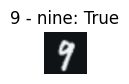

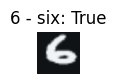

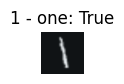

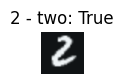

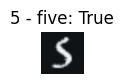

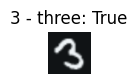

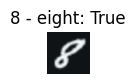

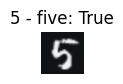

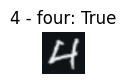

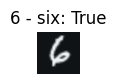

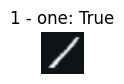

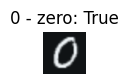

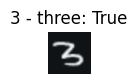

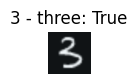

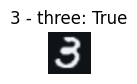

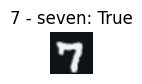

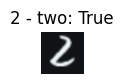

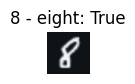

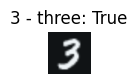

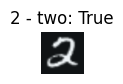

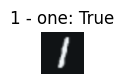

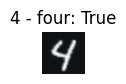

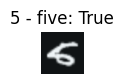

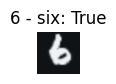

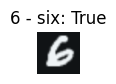

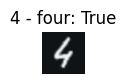

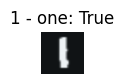

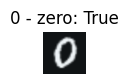

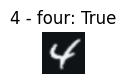

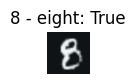

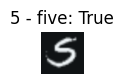

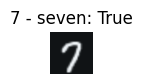

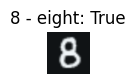

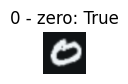

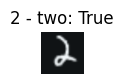

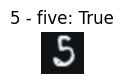

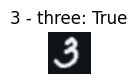

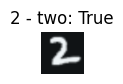

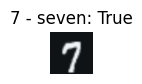

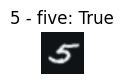

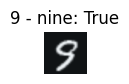

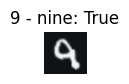

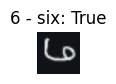

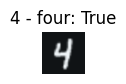

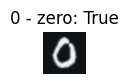

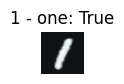

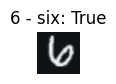

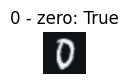

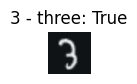

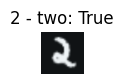

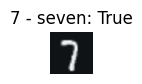

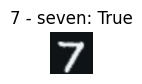

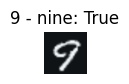

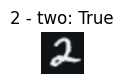

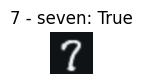

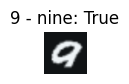

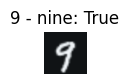

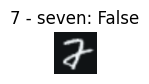

In [39]:
plt.ion()

if use_cuda:
    images, labels = images.cuda(), labels.cuda()

outputs = resnet50(images)
_, preds = torch.max(outputs.data, 1)
preds = preds.cpu().numpy() if use_cuda else preds.numpy()

images_so_far = 0
for i in range(num):
    images_so_far += 1
    ax = plt.subplot(7, 10, images_so_far)
    ax.axis('off')
    res = preds[i] == labels[i]
    ax.set_title('{}: {}'.format(classes[preds[i]], res))
    imshow(images[i])

plt.ioff()